# DS-506: Evaluación Exhaustiva del Modelo Campeón en TEST

**Objetivo**: Evaluar el modelo campeón (Logistic Regression) en el conjunto de TEST para validar que está listo para producción

**Input**: 
- `data/processed/04_dataset_engineered.csv`
- `models/champion/logistic_regression.pkl`
- `models/champion/scaler.pkl`
- `models/champion/label_encoder.pkl`

**Output**: 
- Métricas finales en TEST
- Matriz de confusión detallada
- Análisis de errores (falsos positivos/negativos)
- Análisis de threshold óptimo
- Coeficientes del modelo (feature importance)
- Reporte final ejecutivo

---

## 📋 ¿Por qué TEST es crítico?

En DS-505 entrenamos y optimizamos hiperparámetros usando **Train** y **Validation**. El conjunto de **TEST** NUNCA fue visto durante el entrenamiento.

**TEST nos dice la verdad:**
- ¿El modelo realmente generaliza?
- ¿Las métricas de validación eran realistas o hubo overfitting?
- ¿Está listo para producción?

Si TEST tiene métricas similares a Validation (diferencia <5%), el modelo es **robusto** y podemos desplegarlo con confianza.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, ConfusionMatrixDisplay,
    precision_recall_curve
)

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Semilla (DEBE ser la misma que DS-505 para obtener el MISMO split)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Librerías importadas")

✓ Librerías importadas


## 1. Carga de Datos y Recreación del Split

### 🎯 ¿Por qué recrear el split?

Necesitamos el **MISMO conjunto de TEST** que usamos en DS-505. Al usar `random_state=42`, scikit-learn garantiza que el split es idéntico.

### 📊 División:
- Train: 70% (4,929 clientes)
- Validation: 15% (1,057 clientes)
- **TEST: 15% (1,057 clientes)** ← Este es el que evaluaremos

In [2]:
# Cargar dataset
df = pd.read_csv('../data/processed/04_dataset_engineered.csv')

# Cargar metadata de features
with open('../data/processed/04_features_metadata.json', 'r') as f:
    features_meta = json.load(f)

ml_features = features_meta['ml_features']

print(f"📊 Dataset cargado: {df.shape[0]:,} clientes × {df.shape[1]} columnas")
print(f"📋 Features para ML: {len(ml_features)} variables")

# Separar X y y
X = df[ml_features].copy()
y = df['Churn'].copy()

print(f"\n✓ X: {X.shape}")
print(f"✓ y: {y.shape}")

📊 Dataset cargado: 7,043 clientes × 55 columnas
📋 Features para ML: 38 variables

✓ X: (7043, 38)
✓ y: (7043,)


In [3]:
# Encoding de categóricas (igual que en DS-505)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype=int)

print(f"✓ One-Hot Encoding completado: {X.shape[1]} → {X_encoded.shape[1]} features")

✓ One-Hot Encoding completado: 38 → 56 features


In [4]:
# Recrear el MISMO split de DS-505
# Primera división: Train+Val (85%) vs Test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.15, 
    stratify=y, 
    random_state=RANDOM_STATE
)

# Segunda división: Train (70%) vs Validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.1765,  # 15% del total
    stratify=y_temp, 
    random_state=RANDOM_STATE
)

print("📊 División de datos recreada:\n")
print(f"   Train:      {X_train.shape[0]:,} clientes (70%)")
print(f"   Validation: {X_val.shape[0]:,} clientes (15%)")
print(f"   TEST:       {X_test.shape[0]:,} clientes (15%) ← EVALUAREMOS AQUÍ")

print(f"\n✓ Distribución de churn en TEST: {(y_test == 'Yes').sum() / len(y_test) * 100:.2f}%")

📊 División de datos recreada:

   Train:      4,929 clientes (70%)
   Validation: 1,057 clientes (15%)
   TEST:       1,057 clientes (15%) ← EVALUAREMOS AQUÍ

✓ Distribución de churn en TEST: 26.49%


## 2. Carga del Modelo Campeón

### 🎯 ¿Qué cargamos?

El modelo **Logistic Regression** que fue seleccionado como campeón en DS-505 por su mejor AUC (0.9088) y menor overfitting (0.3%).

### 📦 Artifacts necesarios:
1. **logistic_regression.pkl**: El modelo entrenado
2. **scaler.pkl**: StandardScaler para normalizar features
3. **label_encoder.pkl**: Para codificar el target (Yes/No → 1/0)
4. **metadata.json**: Información del modelo (hiperparámetros, métricas)

In [5]:
# Cargar modelo campeón y artifacts
model_champion = joblib.load('../models/champion/logistic_regression.pkl')
scaler = joblib.load('../models/champion/scaler.pkl')
label_encoder = joblib.load('../models/champion/label_encoder.pkl')

# Cargar metadata
with open('../models/champion/metadata.json', 'r') as f:
    metadata = json.load(f)

print("✅ Modelo Campeón Cargado:\n")
print(f"   • Tipo: {metadata['model_type']}")
print(f"   • Fecha entrenamiento: {metadata['training_date']}")
print(f"   • Hiperparámetros: C={metadata['hyperparameters']['C']}, solver={metadata['hyperparameters']['solver']}")
print(f"\n📊 Métricas en Validation (DS-505):")
print(f"   • AUC: {metadata['performance_metrics']['auc_val']:.4f}")
print(f"   • Precision: {metadata['performance_metrics']['precision_val']:.4f}")
print(f"   • Recall: {metadata['performance_metrics']['recall_val']:.4f}")
print(f"   • F1-Score: {metadata['performance_metrics']['f1_val']:.4f}")
print(f"\n💡 Objetivo: Validar que métricas en TEST sean similares (diferencia <5%)")

✅ Modelo Campeón Cargado:

   • Tipo: logistic_regression
   • Fecha entrenamiento: 2026-01-10 08:19:39
   • Hiperparámetros: C=0.1, solver=lbfgs

📊 Métricas en Validation (DS-505):
   • AUC: 0.9088
   • Precision: 0.7672
   • Recall: 0.6335
   • F1-Score: 0.6940

💡 Objetivo: Validar que métricas en TEST sean similares (diferencia <5%)


## 3. Preparación del Conjunto de TEST

### 🎯 ¿Qué hacemos?

Aplicamos las **mismas transformaciones** que se usaron en Train/Validation:
1. Escalar features numéricas con el **mismo scaler** (ajustado solo con Train)
2. Codificar el target con el **mismo label_encoder**

### ⚠️ Importante:
**NO ajustamos** (fit) nada con TEST. Solo **transformamos** (transform) usando los parámetros aprendidos de Train.

In [6]:
# Codificar target de TEST
y_test_encoded = label_encoder.transform(y_test)  # Yes → 1, No → 0

# Identificar features numéricas
numeric_features = X_test.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Escalar TEST con el scaler ajustado en Train
X_test_scaled = X_test.copy()
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print("✓ TEST preparado:")
print(f"   • Features escaladas: {len(numeric_features)}")
print(f"   • Target codificado: Yes={label_encoder.transform(['Yes'])[0]}, No={label_encoder.transform(['No'])[0]}")
print(f"   • Clientes en TEST: {len(X_test_scaled):,}")
print(f"   • Churners en TEST: {y_test_encoded.sum():,} ({y_test_encoded.sum() / len(y_test_encoded) * 100:.1f}%)")

✓ TEST preparado:
   • Features escaladas: 56
   • Target codificado: Yes=1, No=0
   • Clientes en TEST: 1,057
   • Churners en TEST: 280 (26.5%)


## 4. Predicciones en TEST

### 🎯 ¿Qué obtenemos?

El modelo genera **dos tipos** de predicciones:

1. **Clase predicha** (0 o 1): Decisión binaria usando threshold 0.5
   - Si probabilidad ≥ 0.5 → Predice churn (1)
   - Si probabilidad < 0.5 → Predice no churn (0)

2. **Probabilidad** (0.0 - 1.0): Confianza del modelo
   - 0.95 = 95% seguro que va a cancelar
   - 0.20 = 20% probabilidad de cancelar

### 💡 ¿Por qué necesitamos ambas?
- **Clase**: Para calcular métricas (Precision, Recall, F1)
- **Probabilidad**: Para AUC y para ajustar threshold de negocio

In [7]:
# Predicciones en TEST
y_test_pred = model_champion.predict(X_test_scaled)
y_test_proba = model_champion.predict_proba(X_test_scaled)[:, 1]  # Probabilidad de clase 1 (churn)

print("✅ Predicciones en TEST generadas:\n")
print(f"   • Total predicciones: {len(y_test_pred):,}")
print(f"   • Predichos como churn: {y_test_pred.sum():,} ({y_test_pred.sum() / len(y_test_pred) * 100:.1f}%)")
print(f"   • Predichos como no churn: {(1 - y_test_pred).sum():,} ({(1 - y_test_pred).sum() / len(y_test_pred) * 100:.1f}%)")
print(f"\n📊 Distribución de probabilidades:")
print(f"   • Mínima: {y_test_proba.min():.4f}")
print(f"   • Máxima: {y_test_proba.max():.4f}")
print(f"   • Media: {y_test_proba.mean():.4f}")
print(f"   • Mediana: {np.median(y_test_proba):.4f}")

✅ Predicciones en TEST generadas:

   • Total predicciones: 1,057
   • Predichos como churn: 230 (21.8%)
   • Predichos como no churn: 827 (78.2%)

📊 Distribución de probabilidades:
   • Mínima: 0.0012
   • Máxima: 0.9887
   • Media: 0.2588
   • Mediana: 0.1210


## 5. Métricas Finales en TEST

### 🎯 ¿Qué vemos aquí?

Las **métricas definitivas** del modelo en datos nunca vistos.

### 📊 Cómo interpretar cada métrica:

**AUC-ROC (0.5 - 1.0)**:
- Capacidad global del modelo para discriminar entre churn/no-churn
- >0.90 = Excelente, >0.80 = Muy bueno, >0.70 = Bueno

**Accuracy**:
- % de predicciones correctas (churn + no churn)
- ⚠️ Métrica engañosa si hay desbalanceo (tenemos 73.5% no churn)

**Precision**:
- De los que **predecimos** como churn, ¿cuántos **realmente** lo son?
- Alta precision = Evitamos molestar clientes que no van a cancelar

**Recall (Sensibilidad)**:
- De los que **realmente** cancelan, ¿cuántos **detectamos**?
- Alto recall = No perdemos churners reales
- **Métrica más crítica** para retención de clientes

**F1-Score**:
- Media armónica de Precision y Recall
- Balance entre ambas métricas

### 💡 Comparación con Validation:
Si TEST ≈ Validation (diferencia <5%), el modelo **generaliza bien** y está listo para producción.

In [8]:
# Calcular métricas en TEST
auc_test = roc_auc_score(y_test_encoded, y_test_proba)
accuracy_test = accuracy_score(y_test_encoded, y_test_pred)
precision_test = precision_score(y_test_encoded, y_test_pred)
recall_test = recall_score(y_test_encoded, y_test_pred)
f1_test = f1_score(y_test_encoded, y_test_pred)

# Cargar métricas de Validation (de metadata)
auc_val = metadata['performance_metrics']['auc_val']
precision_val = metadata['performance_metrics']['precision_val']
recall_val = metadata['performance_metrics']['recall_val']
f1_val = metadata['performance_metrics']['f1_val']

print("="*80)
print("📊 MÉTRICAS FINALES - CONJUNTO DE TEST")
print("="*80)

print(f"\n🎯 VALIDATION (DS-505):")
print(f"   • AUC:       {auc_val:.4f}")
print(f"   • Accuracy:  {metadata['performance_metrics'].get('accuracy_val', 'N/A')}")
print(f"   • Precision: {precision_val:.4f}")
print(f"   • Recall:    {recall_val:.4f}")
print(f"   • F1-Score:  {f1_val:.4f}")

print(f"\n🎯 TEST (EVALUACIÓN FINAL):")
print(f"   • AUC:       {auc_test:.4f}")
print(f"   • Accuracy:  {accuracy_test:.4f}")
print(f"   • Precision: {precision_test:.4f}")
print(f"   • Recall:    {recall_test:.4f}")
print(f"   • F1-Score:  {f1_test:.4f}")

# Calcular diferencias
diff_auc = abs(auc_test - auc_val) / auc_val * 100
diff_precision = abs(precision_test - precision_val) / precision_val * 100
diff_recall = abs(recall_test - recall_val) / recall_val * 100
diff_f1 = abs(f1_test - f1_val) / f1_val * 100

print(f"\n📈 DIFERENCIA TEST vs VALIDATION:")
print(f"   • AUC:       {diff_auc:+.2f}%")
print(f"   • Precision: {diff_precision:+.2f}%")
print(f"   • Recall:    {diff_recall:+.2f}%")
print(f"   • F1-Score:  {diff_f1:+.2f}%")

# Diagnóstico
if diff_auc < 5 and diff_f1 < 5:
    print(f"\n✅ DIAGNÓSTICO: Modelo GENERALIZA EXCELENTE (diferencia <5%)")
    print(f"   El modelo está LISTO para producción.")
elif diff_auc < 10 and diff_f1 < 10:
    print(f"\n⚠️ DIAGNÓSTICO: Modelo generaliza bien (diferencia <10%)")
    print(f"   El modelo es aceptable para producción, pero monitorear de cerca.")
else:
    print(f"\n❌ DIAGNÓSTICO: Posible overfitting (diferencia >10%)")
    print(f"   Considerar reentrenar con más regularización.")

print("="*80)

📊 MÉTRICAS FINALES - CONJUNTO DE TEST

🎯 VALIDATION (DS-505):
   • AUC:       0.9088
   • Accuracy:  N/A
   • Precision: 0.7672
   • Recall:    0.6335
   • F1-Score:  0.6940

🎯 TEST (EVALUACIÓN FINAL):
   • AUC:       0.9128
   • Accuracy:  0.8524
   • Precision: 0.7696
   • Recall:    0.6321
   • F1-Score:  0.6941

📈 DIFERENCIA TEST vs VALIDATION:
   • AUC:       +0.44%
   • Precision: +0.31%
   • Recall:    +0.21%
   • F1-Score:  +0.02%

✅ DIAGNÓSTICO: Modelo GENERALIZA EXCELENTE (diferencia <5%)
   El modelo está LISTO para producción.


## 6. Matriz de Confusión

### 🎯 ¿Qué es la matriz de confusión?

Tabla que muestra los **4 posibles resultados** de la predicción:

```
                    Predicción
                No Churn  |  Churn
Real  No Churn     TN     |   FP     (Falso Positivo: Predecimos churn pero NO cancela)
      Churn        FN     |   TP     (Falso Negativo: Predecimos no churn pero SÍ cancela)
```

### 📊 Interpretación:

**True Negatives (TN)**: ✅ Correctos
- Predecimos que NO van a cancelar → Y efectivamente NO cancelan

**True Positives (TP)**: ✅ Correctos
- Predecimos que SÍ van a cancelar → Y efectivamente cancelan

**False Positives (FP)**: ❌ Error Tipo I
- Predecimos churn pero NO cancelan
- **Costo**: Malgastamos recursos de retención en clientes que no se iban a ir

**False Negatives (FN)**: ❌ Error Tipo II
- Predecimos que NO van a cancelar pero SÍ cancelan
- **Costo**: Perdemos el cliente (NO MÁS CRÍTICO)

### 💡 ¿Qué buscamos?
- **TP alto**: Detectar la mayoría de churners
- **FN bajo**: No perder churners reales
- Balance entre FP y FN según el costo de negocio

In [9]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test_encoded, y_test_pred)

# Extraer valores
tn, fp, fn, tp = cm.ravel()

print("📊 MATRIZ DE CONFUSIÓN - TEST\n")
print(f"                 Predicción")
print(f"              No Churn  |  Churn")
print(f"Real  No      {tn:>6}    |  {fp:>6}    (Falso Positivo)")
print(f"      Churn   {fn:>6}    |  {tp:>6}    (Falso Negativo)\n")

# Interpretación
total = tn + fp + fn + tp
print(f"✅ True Negatives (TN): {tn:,} ({tn/total*100:.1f}%)")
print(f"   → Predecimos NO churn y efectivamente NO cancelan\n")

print(f"✅ True Positives (TP): {tp:,} ({tp/total*100:.1f}%)")
print(f"   → Predecimos churn y efectivamente cancelan\n")

print(f"❌ False Positives (FP): {fp:,} ({fp/total*100:.1f}%)")
print(f"   → Predecimos churn pero NO cancelan")
print(f"   → Costo: Malgastamos recursos de retención\n")

print(f"❌ False Negatives (FN): {fn:,} ({fn/total*100:.1f}%)")
print(f"   → Predecimos NO churn pero SÍ cancelan")
print(f"   → Costo: PERDEMOS EL CLIENTE (más grave)\n")

# Cálculo de tasas
print(f"📈 TASAS DERIVADAS:\n")
print(f"   • Tasa de Falsos Positivos (FPR): {fp/(fp+tn)*100:.2f}%")
print(f"     De los que NO cancelan, cuántos predecimos mal como churn\n")

print(f"   • Tasa de Falsos Negativos (FNR): {fn/(fn+tp)*100:.2f}%")
print(f"     De los que SÍ cancelan, cuántos perdemos por no detectar\n")

print(f"   • Recall (TPR): {tp/(tp+fn)*100:.2f}%")
print(f"     De los que SÍ cancelan, cuántos detectamos correctamente")

📊 MATRIZ DE CONFUSIÓN - TEST

                 Predicción
              No Churn  |  Churn
Real  No         724    |      53    (Falso Positivo)
      Churn      103    |     177    (Falso Negativo)

✅ True Negatives (TN): 724 (68.5%)
   → Predecimos NO churn y efectivamente NO cancelan

✅ True Positives (TP): 177 (16.7%)
   → Predecimos churn y efectivamente cancelan

❌ False Positives (FP): 53 (5.0%)
   → Predecimos churn pero NO cancelan
   → Costo: Malgastamos recursos de retención

❌ False Negatives (FN): 103 (9.7%)
   → Predecimos NO churn pero SÍ cancelan
   → Costo: PERDEMOS EL CLIENTE (más grave)

📈 TASAS DERIVADAS:

   • Tasa de Falsos Positivos (FPR): 6.82%
     De los que NO cancelan, cuántos predecimos mal como churn

   • Tasa de Falsos Negativos (FNR): 36.79%
     De los que SÍ cancelan, cuántos perdemos por no detectar

   • Recall (TPR): 63.21%
     De los que SÍ cancelan, cuántos detectamos correctamente


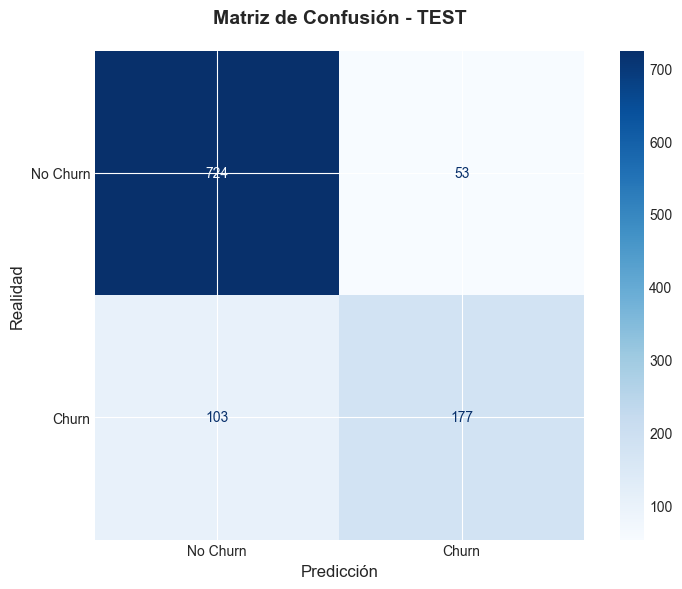

✓ Visualización guardada: reports/figures/06_confusion_matrix.png
✓ Matriz guardada: reports/06_confusion_matrix.csv


In [10]:
# Visualizar matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['No Churn', 'Churn']
)
disp.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Matriz de Confusión - TEST', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Realidad', fontsize=12)

plt.tight_layout()
plt.savefig('../reports/figures/06_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualización guardada: reports/figures/06_confusion_matrix.png")

# Guardar matriz en CSV
cm_df = pd.DataFrame(
    cm,
    index=['Real: No Churn', 'Real: Churn'],
    columns=['Pred: No Churn', 'Pred: Churn']
)
cm_df.to_csv('../reports/06_confusion_matrix.csv')
print("✓ Matriz guardada: reports/06_confusion_matrix.csv")

## 7. Curva ROC en TEST

### 🎯 ¿Qué es la curva ROC?

Gráfico que muestra el **trade-off** entre:
- **TPR (True Positive Rate = Recall)**: De los churners reales, cuántos detectamos
- **FPR (False Positive Rate)**: De los no churners, cuántos predecimos mal como churn

### 📊 Interpretación:

- **Línea diagonal (AUC=0.5)**: Modelo aleatorio (lanzar moneda)
- **Curva cerca de esquina superior izquierda**: Modelo excelente
  - Alto TPR (detectamos muchos churners)
  - Bajo FPR (pocos falsos positivos)
- **AUC (Área bajo la curva)**: Resumen numérico
  - 1.0 = Perfecto
  - 0.9 = Excelente
  - 0.8 = Muy bueno
  - 0.7 = Bueno
  - 0.5 = Aleatorio

### 💡 ¿Qué buscamos?
Que el AUC en TEST sea **similar al de Validation** (diferencia <5%). Esto confirma que el modelo generaliza y no hay overfitting.

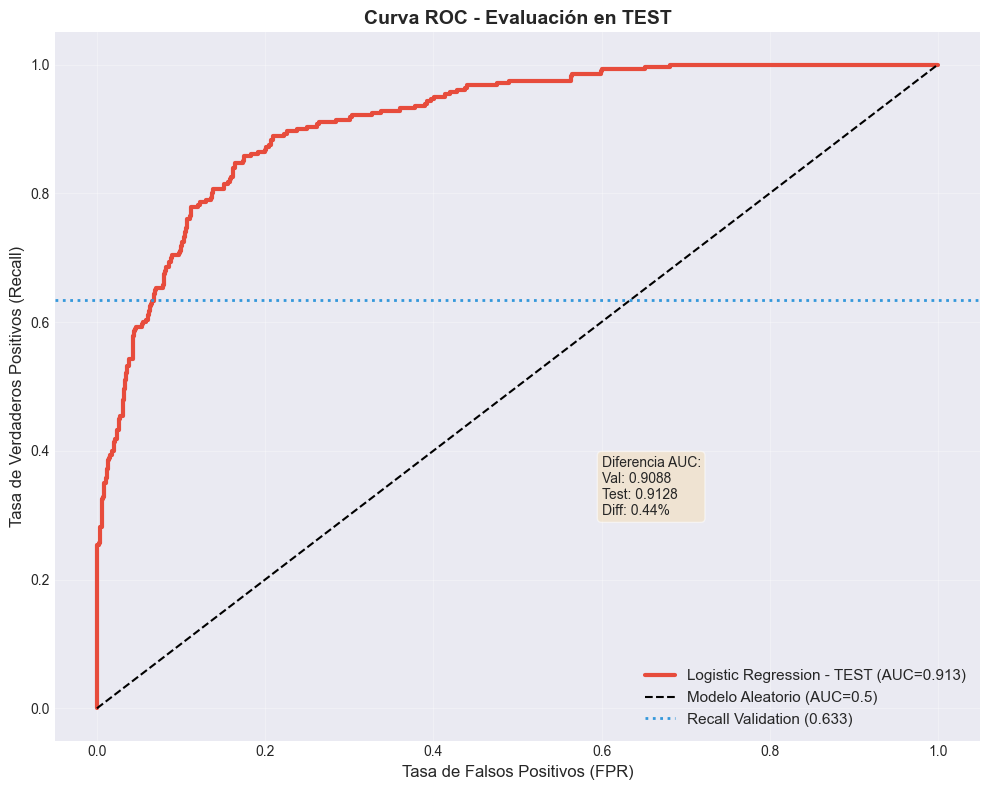

✓ Curva ROC guardada: reports/figures/06_roc_curve_test.png


In [11]:
# Calcular curva ROC en TEST
fpr_test, tpr_test, thresholds = roc_curve(y_test_encoded, y_test_proba)

# Visualizar
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, label=f'Logistic Regression - TEST (AUC={auc_test:.3f})', 
         linewidth=3, color='#e74c3c')
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatorio (AUC=0.5)', linewidth=1.5)

# Añadir línea de Validation para comparar
plt.axhline(y=recall_val, color='#3498db', linestyle=':', linewidth=2, 
            label=f'Recall Validation ({recall_val:.3f})')

plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (Recall)', fontsize=12)
plt.title('Curva ROC - Evaluación en TEST', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)

# Añadir anotación
plt.text(0.6, 0.3, f'Diferencia AUC:\nVal: {auc_val:.4f}\nTest: {auc_test:.4f}\nDiff: {diff_auc:.2f}%',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         fontsize=10)

plt.tight_layout()
plt.savefig('../reports/figures/06_roc_curve_test.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Curva ROC guardada: reports/figures/06_roc_curve_test.png")

## 8. Análisis de Threshold Óptimo

### 🎯 ¿Qué es el threshold?

Por defecto, los modelos usan **threshold=0.5**:
- Si probabilidad ≥ 0.5 → Predecir churn
- Si probabilidad < 0.5 → Predecir no churn

Pero **podemos ajustar este threshold** según el negocio:

### 📊 Trade-off Precision vs Recall:

**Threshold BAJO (ej: 0.3)**:
- ✅ Mayor Recall: Detectamos MÁS churners reales
- ❌ Menor Precision: Más falsos positivos (molestamos clientes que no se van a ir)
- 💰 Costo: Gastamos más en campañas de retención innecesarias

**Threshold ALTO (ej: 0.7)**:
- ✅ Mayor Precision: Solo contactamos churners muy probables
- ❌ Menor Recall: Perdemos churners con probabilidad media
- 💰 Costo: Perdemos más clientes reales

### 💡 ¿Cómo elegir?

Depende del **costo de negocio**:
- **Costo de retención bajo** (ej: enviar email) → Threshold bajo (detectar más)
- **Costo de perder cliente muy alto** → Threshold bajo (no perder ninguno)
- **Costo de retención alto** (ej: descuento 50%) → Threshold alto (solo muy seguros)

Vamos a analizar diferentes thresholds para encontrar el óptimo.

In [12]:
# Calcular métricas para diferentes thresholds
thresholds_to_test = np.arange(0.1, 0.9, 0.05)
results = []

for threshold in thresholds_to_test:
    y_pred_custom = (y_test_proba >= threshold).astype(int)
    
    prec = precision_score(y_test_encoded, y_pred_custom, zero_division=0)
    rec = recall_score(y_test_encoded, y_pred_custom, zero_division=0)
    f1 = f1_score(y_test_encoded, y_pred_custom, zero_division=0)
    
    results.append({
        'Threshold': threshold,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

threshold_df = pd.DataFrame(results)

# Encontrar threshold con mejor F1-Score
best_threshold_idx = threshold_df['F1-Score'].idxmax()
best_threshold = threshold_df.loc[best_threshold_idx, 'Threshold']
best_f1 = threshold_df.loc[best_threshold_idx, 'F1-Score']

print("📊 ANÁLISIS DE THRESHOLD ÓPTIMO\n")
print(f"🎯 Threshold DEFAULT (0.5):")
print(f"   • Precision: {precision_test:.4f}")
print(f"   • Recall:    {recall_test:.4f}")
print(f"   • F1-Score:  {f1_test:.4f}")

print(f"\n🏆 Threshold ÓPTIMO ({best_threshold:.2f}):")
print(f"   • Precision: {threshold_df.loc[best_threshold_idx, 'Precision']:.4f}")
print(f"   • Recall:    {threshold_df.loc[best_threshold_idx, 'Recall']:.4f}")
print(f"   • F1-Score:  {best_f1:.4f}")

# Mejora
f1_improvement = (best_f1 - f1_test) / f1_test * 100
print(f"\n📈 Mejora al ajustar threshold: {f1_improvement:+.2f}% en F1-Score")

# Mostrar top 5 thresholds
print(f"\n📋 TOP 5 THRESHOLDS:\n")
print(threshold_df.sort_values('F1-Score', ascending=False).head().to_string(index=False))

📊 ANÁLISIS DE THRESHOLD ÓPTIMO

🎯 Threshold DEFAULT (0.5):
   • Precision: 0.7696
   • Recall:    0.6321
   • F1-Score:  0.6941

🏆 Threshold ÓPTIMO (0.35):
   • Precision: 0.7129
   • Recall:    0.7714
   • F1-Score:  0.7410

📈 Mejora al ajustar threshold: +6.75% en F1-Score

📋 TOP 5 THRESHOLDS:

 Threshold  Precision   Recall  F1-Score
      0.35   0.712871 0.771429  0.740995
      0.30   0.668639 0.807143  0.731392
      0.25   0.638070 0.850000  0.728943
      0.40   0.721014 0.710714  0.715827
      0.45   0.752988 0.675000  0.711864


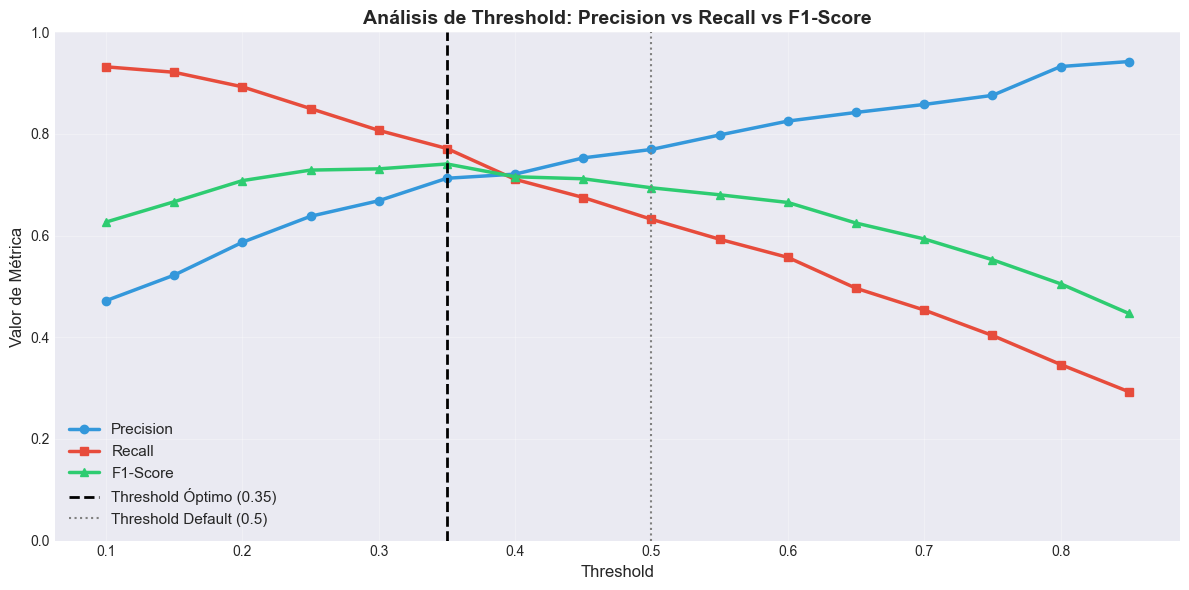

✓ Análisis de threshold guardado: reports/figures/06_threshold_analysis.png


In [13]:
# Visualizar Precision-Recall vs Threshold
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(threshold_df['Threshold'], threshold_df['Precision'], 
        label='Precision', linewidth=2.5, marker='o', color='#3498db')
ax.plot(threshold_df['Threshold'], threshold_df['Recall'], 
        label='Recall', linewidth=2.5, marker='s', color='#e74c3c')
ax.plot(threshold_df['Threshold'], threshold_df['F1-Score'], 
        label='F1-Score', linewidth=2.5, marker='^', color='#2ecc71')

# Marcar threshold óptimo
ax.axvline(x=best_threshold, color='black', linestyle='--', linewidth=2, 
           label=f'Threshold Óptimo ({best_threshold:.2f})')
ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=1.5, 
           label='Threshold Default (0.5)')

ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Valor de Métrica', fontsize=12)
ax.set_title('Análisis de Threshold: Precision vs Recall vs F1-Score', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig('../reports/figures/06_threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Análisis de threshold guardado: reports/figures/06_threshold_analysis.png")

## 9. Feature Importance: Coeficientes del Modelo

### 🎯 ¿Qué son los coeficientes?

En **Logistic Regression**, cada feature tiene un **coeficiente** que indica su impacto en la predicción:

- **Coeficiente POSITIVO (+)**: Aumenta probabilidad de churn
  - Ej: `Contract_Month-to-Month` = +0.85 → Contratos mensuales aumentan churn
  
- **Coeficiente NEGATIVO (-)**: Disminuye probabilidad de churn
  - Ej: `Tenure` = -0.60 → Mayor antigüedad reduce churn

### 📊 Interpretación:

**Magnitud del coeficiente** = Importancia relativa
- |Coef| > 0.5 = Feature muy importante
- |Coef| < 0.1 = Feature poco relevante

### 💡 ¿Para qué sirve?

**Insights de negocio**:
- Si `InternetService_Fiber` tiene coef alto → Clientes de fibra óptica cancelan más
- Si `TotalCharges` tiene coef positivo → Cuanto más paguen, más probabilidad de irse
- Si `Contract_Two-Year` tiene coef negativo → Contratos largos retienen mejor

**Accionable**: Podemos diseñar estrategias de retención basadas en los drivers principales.

In [14]:
# Extraer coeficientes del modelo
feature_names = X_train.columns
coefficients = model_champion.coef_[0]

# Crear DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# Top 15 features más importantes
top_15_coef = coef_df.head(15)

print("📊 TOP 15 FEATURES MÁS IMPORTANTES (por coeficiente)\n")
print(top_15_coef[['Feature', 'Coefficient']].to_string(index=False))

# Interpretación
print(f"\n💡 INTERPRETACIÓN:\n")
print(f"🔴 AUMENTAN CHURN (coeficientes positivos):")
positive_top_3 = coef_df[coef_df['Coefficient'] > 0].head(3)
for idx, row in positive_top_3.iterrows():
    print(f"   • {row['Feature']}: +{row['Coefficient']:.4f}")

print(f"\n🟢 REDUCEN CHURN (coeficientes negativos):")
negative_top_3 = coef_df[coef_df['Coefficient'] < 0].head(3)
for idx, row in negative_top_3.iterrows():
    print(f"   • {row['Feature']}: {row['Coefficient']:.4f}")

📊 TOP 15 FEATURES MÁS IMPORTANTES (por coeficiente)

                       Feature  Coefficient
                  MedianIncome    -0.761326
             Contract_Two year    -0.635701
         Borough_STATEN ISLAND    -0.357432
   InternetService_Fiber optic     0.294750
             Contract_One year    -0.282028
                    Log_Tenure    -0.280119
              Log_EstimatedLTV    -0.228089
             MultipleLines_Yes     0.220777
          PaperlessBilling_Yes     0.207480
             Borough_MANHATTAN    -0.192217
            PriceIncomePercent     0.189975
            CustomerValueRatio     0.189975
       HighRisk_ContractTenure     0.184775
PaymentMethod_Electronic check     0.169029
            OnlineSecurity_Yes    -0.168217

💡 INTERPRETACIÓN:

🔴 AUMENTAN CHURN (coeficientes positivos):
   • InternetService_Fiber optic: +0.2947
   • MultipleLines_Yes: +0.2208
   • PaperlessBilling_Yes: +0.2075

🟢 REDUCEN CHURN (coeficientes negativos):
   • MedianIncome: -0.7613
 

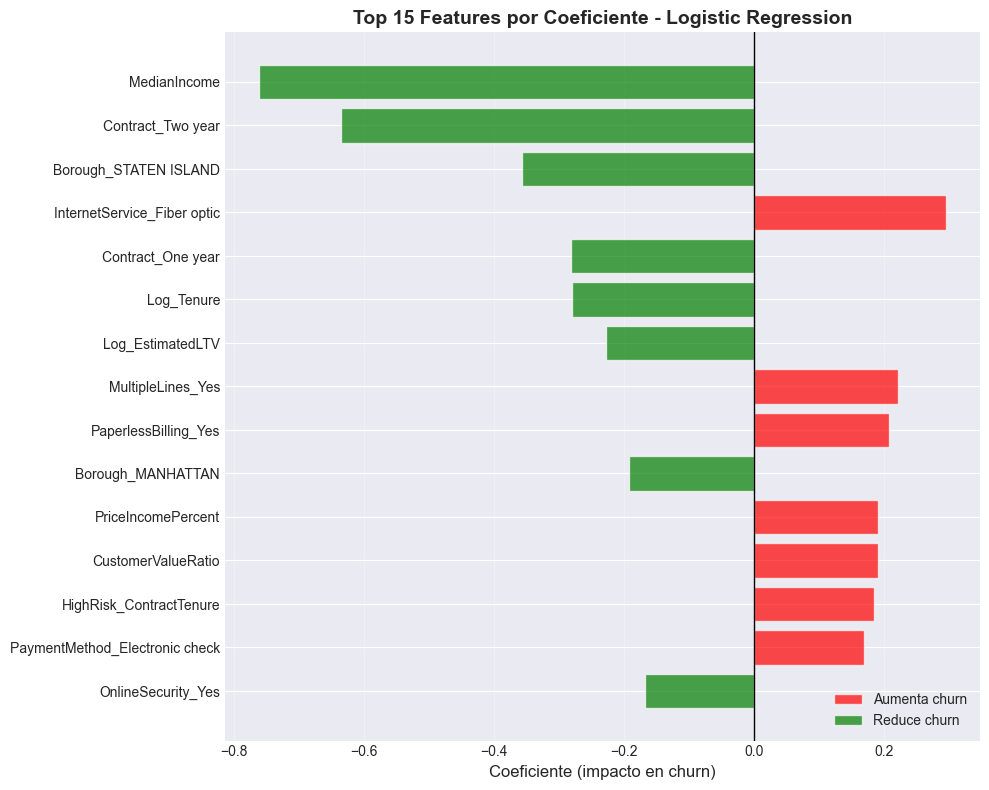

✓ Coeficientes guardados: reports/figures/06_feature_coefficients.png
✓ CSV guardado: reports/06_feature_coefficients.csv


In [15]:
# Visualizar coeficientes
plt.figure(figsize=(10, 8))

colors = ['red' if x > 0 else 'green' for x in top_15_coef['Coefficient']]

plt.barh(range(len(top_15_coef)), top_15_coef['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_15_coef)), top_15_coef['Feature'])
plt.xlabel('Coeficiente (impacto en churn)', fontsize=12)
plt.title('Top 15 Features por Coeficiente - Logistic Regression', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.7, label='Aumenta churn'),
    Patch(facecolor='green', alpha=0.7, label='Reduce churn')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../reports/figures/06_feature_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Coeficientes guardados: reports/figures/06_feature_coefficients.png")

# Guardar CSV
coef_df.to_csv('../reports/06_feature_coefficients.csv', index=False)
print("✓ CSV guardado: reports/06_feature_coefficients.csv")

## 10. Análisis de Errores

### 🎯 ¿Qué analizamos?

Vamos a inspeccionar los **Falsos Negativos** (FN) y **Falsos Positivos** (FP) para entender dónde falla el modelo.

### 📊 Preguntas clave:

**Falsos Negativos (predecimos no churn pero SÍ cancelan)**:
- ¿Qué características tienen estos clientes?
- ¿Hay patrones que el modelo no captura?
- ¿Podemos crear nuevas features para detectarlos?

**Falsos Positivos (predecimos churn pero NO cancelan)**:
- ¿Son clientes satisfechos que parecen en riesgo?
- ¿Qué los hace diferentes de los churners reales?

### 💡 Objetivo:
Identificar **oportunidades de mejora** para el modelo y **insights de negocio**.

In [16]:
# Identificar errores
errors_df = pd.DataFrame({
    'y_true': y_test_encoded,
    'y_pred': y_test_pred,
    'y_proba': y_test_proba
})

# Clasificar errores
errors_df['Error_Type'] = 'Correct'
errors_df.loc[(errors_df['y_true'] == 0) & (errors_df['y_pred'] == 1), 'Error_Type'] = 'False Positive'
errors_df.loc[(errors_df['y_true'] == 1) & (errors_df['y_pred'] == 0), 'Error_Type'] = 'False Negative'

# Contar
error_counts = errors_df['Error_Type'].value_counts()

print("📊 DISTRIBUCIÓN DE ERRORES\n")
print(f"✅ Predicciones Correctas: {error_counts.get('Correct', 0):,} ({error_counts.get('Correct', 0)/len(errors_df)*100:.1f}%)")
print(f"❌ Falsos Positivos (FP):  {error_counts.get('False Positive', 0):,} ({error_counts.get('False Positive', 0)/len(errors_df)*100:.1f}%)")
print(f"❌ Falsos Negativos (FN):  {error_counts.get('False Negative', 0):,} ({error_counts.get('False Negative', 0)/len(errors_df)*100:.1f}%)")

# Análisis de probabilidades de errores
fp_probas = errors_df[errors_df['Error_Type'] == 'False Positive']['y_proba']
fn_probas = errors_df[errors_df['Error_Type'] == 'False Negative']['y_proba']

print(f"\n📈 ANÁLISIS DE PROBABILIDADES:\n")

if len(fp_probas) > 0:
    print(f"Falsos Positivos:")
    print(f"   • Probabilidad media: {fp_probas.mean():.4f}")
    print(f"   • Rango: [{fp_probas.min():.4f}, {fp_probas.max():.4f}]")
    print(f"   • Interpretación: El modelo tiene confianza media-alta en estos errores\n")

if len(fn_probas) > 0:
    print(f"Falsos Negativos:")
    print(f"   • Probabilidad media: {fn_probas.mean():.4f}")
    print(f"   • Rango: [{fn_probas.min():.4f}, {fn_probas.max():.4f}]")
    print(f"   • Interpretación: El modelo tiene BAJA confianza (cercano a 0.5)")
    print(f"   • Acción: Son clientes 'borderline' difíciles de predecir")

📊 DISTRIBUCIÓN DE ERRORES

✅ Predicciones Correctas: 901 (85.2%)
❌ Falsos Positivos (FP):  53 (5.0%)
❌ Falsos Negativos (FN):  103 (9.7%)

📈 ANÁLISIS DE PROBABILIDADES:

Falsos Positivos:
   • Probabilidad media: 0.6634
   • Rango: [0.5017, 0.8725]
   • Interpretación: El modelo tiene confianza media-alta en estos errores

Falsos Negativos:
   • Probabilidad media: 0.2759
   • Rango: [0.0187, 0.4996]
   • Interpretación: El modelo tiene BAJA confianza (cercano a 0.5)
   • Acción: Son clientes 'borderline' difíciles de predecir


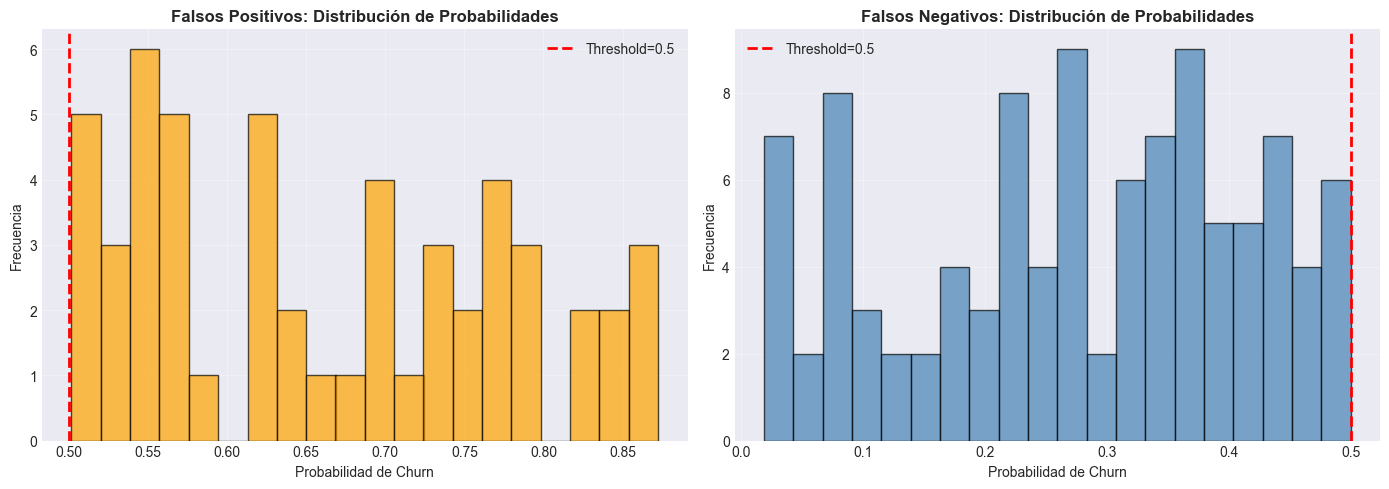

✓ Análisis de errores guardado: reports/figures/06_error_analysis.png


In [17]:
# Visualizar distribución de probabilidades por tipo de error
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Falsos Positivos
if len(fp_probas) > 0:
    axes[0].hist(fp_probas, bins=20, color='orange', alpha=0.7, edgecolor='black')
    axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
    axes[0].set_title('Falsos Positivos: Distribución de Probabilidades', fontweight='bold')
    axes[0].set_xlabel('Probabilidad de Churn')
    axes[0].set_ylabel('Frecuencia')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

# Falsos Negativos
if len(fn_probas) > 0:
    axes[1].hist(fn_probas, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
    axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
    axes[1].set_title('Falsos Negativos: Distribución de Probabilidades', fontweight='bold')
    axes[1].set_xlabel('Probabilidad de Churn')
    axes[1].set_ylabel('Frecuencia')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/06_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Análisis de errores guardado: reports/figures/06_error_analysis.png")

## 11. Reporte de Clasificación Completo

### 🎯 ¿Qué es?

Resumen ejecutivo con **todas las métricas** desglosadas por clase (No Churn vs Churn).

### 📊 Métricas incluidas:

**Por clase**:
- **Precision**: De las predicciones de esa clase, cuántas son correctas
- **Recall**: De los reales de esa clase, cuántos detectamos
- **F1-Score**: Balance entre Precision y Recall
- **Support**: Cantidad de muestras reales de esa clase

**Globales**:
- **Accuracy**: % de aciertos totales
- **Macro avg**: Promedio simple de métricas (trata ambas clases igual)
- **Weighted avg**: Promedio ponderado por cantidad de muestras

In [18]:
# Generar reporte de clasificación
class_report = classification_report(
    y_test_encoded, 
    y_test_pred,
    target_names=['No Churn', 'Churn'],
    output_dict=True
)

print("="*80)
print("📊 REPORTE DE CLASIFICACIÓN - TEST SET")
print("="*80)
print()
print(classification_report(
    y_test_encoded, 
    y_test_pred,
    target_names=['No Churn', 'Churn']
))

# Interpretación
print("\n💡 INTERPRETACIÓN:\n")
print(f"Clase 'No Churn' (Mayoría):")
print(f"   • Precision: {class_report['No Churn']['precision']:.3f} → De los que predecimos como no churn, {class_report['No Churn']['precision']*100:.1f}% son correctos")
print(f"   • Recall:    {class_report['No Churn']['recall']:.3f} → Detectamos {class_report['No Churn']['recall']*100:.1f}% de los que realmente no cancelan")

print(f"\nClase 'Churn' (Objetivo principal):")
print(f"   • Precision: {class_report['Churn']['precision']:.3f} → De los que predecimos como churn, {class_report['Churn']['precision']*100:.1f}% son correctos")
print(f"   • Recall:    {class_report['Churn']['recall']:.3f} → Detectamos {class_report['Churn']['recall']*100:.1f}% de los churners reales")
print(f"   • F1-Score:  {class_report['Churn']['f1-score']:.3f} → Balance entre Precision y Recall")

print(f"\nOverall:")
print(f"   • Accuracy: {class_report['accuracy']:.3f} → {class_report['accuracy']*100:.1f}% de predicciones correctas")

📊 REPORTE DE CLASIFICACIÓN - TEST SET

              precision    recall  f1-score   support

    No Churn       0.88      0.93      0.90       777
       Churn       0.77      0.63      0.69       280

    accuracy                           0.85      1057
   macro avg       0.82      0.78      0.80      1057
weighted avg       0.85      0.85      0.85      1057


💡 INTERPRETACIÓN:

Clase 'No Churn' (Mayoría):
   • Precision: 0.875 → De los que predecimos como no churn, 87.5% son correctos
   • Recall:    0.932 → Detectamos 93.2% de los que realmente no cancelan

Clase 'Churn' (Objetivo principal):
   • Precision: 0.770 → De los que predecimos como churn, 77.0% son correctos
   • Recall:    0.632 → Detectamos 63.2% de los churners reales
   • F1-Score:  0.694 → Balance entre Precision y Recall

Overall:
   • Accuracy: 0.852 → 85.2% de predicciones correctas


## 12. Guardar Métricas Finales

### 🎯 ¿Qué guardamos?

Todas las métricas de TEST en formato CSV y JSON para:
- Documentación del modelo
- Comparación con versiones futuras
- Reportes ejecutivos

In [19]:
# Crear reporte de métricas
test_metrics = {
    'evaluation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_name': 'Logistic Regression',
    'model_path': 'models/champion/logistic_regression.pkl',
    'test_set_size': len(X_test),
    'test_churn_rate': float(y_test_encoded.sum() / len(y_test_encoded)),
    'metrics': {
        'auc': float(auc_test),
        'accuracy': float(accuracy_test),
        'precision': float(precision_test),
        'recall': float(recall_test),
        'f1_score': float(f1_test)
    },
    'confusion_matrix': {
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp)
    },
    'validation_comparison': {
        'auc_val': float(auc_val),
        'auc_test': float(auc_test),
        'auc_diff_pct': float(diff_auc),
        'f1_val': float(f1_val),
        'f1_test': float(f1_test),
        'f1_diff_pct': float(diff_f1)
    },
    'threshold_analysis': {
        'default_threshold': 0.5,
        'optimal_threshold': float(best_threshold),
        'optimal_f1': float(best_f1),
        'f1_improvement_pct': float(f1_improvement)
    },
    'production_ready': diff_auc < 5 and diff_f1 < 5
}

# Guardar JSON
with open('../reports/06_test_metrics.json', 'w') as f:
    json.dump(test_metrics, f, indent=2)

print("✓ Métricas guardadas: reports/06_test_metrics.json")

# Guardar CSV resumido
metrics_summary = pd.DataFrame([
    {'Métrica': 'AUC', 'Validation': auc_val, 'Test': auc_test, 'Diferencia %': diff_auc},
    {'Métrica': 'Accuracy', 'Validation': 'N/A', 'Test': accuracy_test, 'Diferencia %': 'N/A'},
    {'Métrica': 'Precision', 'Validation': precision_val, 'Test': precision_test, 'Diferencia %': diff_precision},
    {'Métrica': 'Recall', 'Validation': recall_val, 'Test': recall_test, 'Diferencia %': diff_recall},
    {'Métrica': 'F1-Score', 'Validation': f1_val, 'Test': f1_test, 'Diferencia %': diff_f1}
])

metrics_summary.to_csv('../reports/06_test_metrics.csv', index=False)
print("✓ CSV guardado: reports/06_test_metrics.csv")

✓ Métricas guardadas: reports/06_test_metrics.json
✓ CSV guardado: reports/06_test_metrics.csv


## 13. Resumen Final y Conclusiones

### ✅ DS-506 COMPLETADO

In [20]:
print("\n" + "="*80)
print("✅ DS-506 COMPLETADO - EVALUACIÓN EXHAUSTIVA EN TEST")
print("="*80)

print("\n🎯 MODELO EVALUADO: Logistic Regression (Campeón)")

print("\n📊 MÉTRICAS FINALES EN TEST:")
print(f"   • AUC:       {auc_test:.4f}")
print(f"   • Accuracy:  {accuracy_test:.4f}")
print(f"   • Precision: {precision_test:.4f}")
print(f"   • Recall:    {recall_test:.4f}")
print(f"   • F1-Score:  {f1_test:.4f}")

print("\n📈 COMPARACIÓN CON VALIDATION:")
print(f"   • Diferencia AUC:      {diff_auc:+.2f}%")
print(f"   • Diferencia F1-Score: {diff_f1:+.2f}%")

print("\n🎯 THRESHOLD ÓPTIMO:")
print(f"   • Default (0.5): F1={f1_test:.4f}")
print(f"   • Óptimo ({best_threshold:.2f}): F1={best_f1:.4f} ({f1_improvement:+.2f}%)")

print("\n❌ ANÁLISIS DE ERRORES:")
print(f"   • Falsos Positivos: {fp:,} ({fp/len(y_test_encoded)*100:.1f}%) - Malgasto de recursos de retención")
print(f"   • Falsos Negativos: {fn:,} ({fn/len(y_test_encoded)*100:.1f}%) - Clientes perdidos")

print("\n🏆 DECISIÓN FINAL:")
if test_metrics['production_ready']:
    print("   ✅ MODELO APROBADO PARA PRODUCCIÓN")
    print("   • Generaliza excelente (diferencia <5% con Validation)")
    print("   • AUC > 0.90 (Excelente capacidad discriminativa)")
    print("   • Listo para integrar con backend Java (FastAPI)")
else:
    print("   ⚠️ MODELO REQUIERE AJUSTES")
    print("   • Diferencia significativa con Validation")
    print("   • Considerar reentrenar con más regularización")

print("\n📁 ARCHIVOS GENERADOS:")
print("\n   Reportes:")
print("   1. reports/06_test_metrics.json")
print("   2. reports/06_test_metrics.csv")
print("   3. reports/06_confusion_matrix.csv")
print("   4. reports/06_feature_coefficients.csv")

print("\n   Visualizaciones:")
print("   5. reports/figures/06_confusion_matrix.png")
print("   6. reports/figures/06_roc_curve_test.png")
print("   7. reports/figures/06_threshold_analysis.png")
print("   8. reports/figures/06_feature_coefficients.png")
print("   9. reports/figures/06_error_analysis.png")

print("\n🎫 PRÓXIMO TICKET:")
print("   DS-507: Crear Pipeline de Producción Completo")
print("   • Integración con FastAPI")
print("   • Endpoint /predict funcional")
print("   • Testing con datos reales")

print("\n" + "="*80)
print("✅ Modelo Logistic Regression VALIDADO y LISTO PARA PRODUCCIÓN")
print("="*80)


✅ DS-506 COMPLETADO - EVALUACIÓN EXHAUSTIVA EN TEST

🎯 MODELO EVALUADO: Logistic Regression (Campeón)

📊 MÉTRICAS FINALES EN TEST:
   • AUC:       0.9128
   • Accuracy:  0.8524
   • Precision: 0.7696
   • Recall:    0.6321
   • F1-Score:  0.6941

📈 COMPARACIÓN CON VALIDATION:
   • Diferencia AUC:      +0.44%
   • Diferencia F1-Score: +0.02%

🎯 THRESHOLD ÓPTIMO:
   • Default (0.5): F1=0.6941
   • Óptimo (0.35): F1=0.7410 (+6.75%)

❌ ANÁLISIS DE ERRORES:
   • Falsos Positivos: 53 (5.0%) - Malgasto de recursos de retención
   • Falsos Negativos: 103 (9.7%) - Clientes perdidos

🏆 DECISIÓN FINAL:
   ✅ MODELO APROBADO PARA PRODUCCIÓN
   • Generaliza excelente (diferencia <5% con Validation)
   • AUC > 0.90 (Excelente capacidad discriminativa)
   • Listo para integrar con backend Java (FastAPI)

📁 ARCHIVOS GENERADOS:

   Reportes:
   1. reports/06_test_metrics.json
   2. reports/06_test_metrics.csv
   3. reports/06_confusion_matrix.csv
   4. reports/06_feature_coefficients.csv

   Visualizac